# Sheet01
## Loading the data

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

## Extract necessary data

In [3]:
import numpy as np

X = []
y = []
for i in range(target.shape[0]):
    if target[i]==3:
        X.append(data[i])
        y.append(1)
    elif target[i]==8:
        X.append(data[i])
        y.append(-1)
    else: continue

y = np.array(y)
X = np.array(X)
ones = np.ones(X.shape[0],dtype=float)
ones = ones[:, np.newaxis]
X = np.concatenate((X, ones),axis=1)
print("Shape of X is:", X.shape)
print("Shape of y is:", y.shape)

Shape of X is: (357, 65)
Shape of y is: (357,)


## Logistic Regression and Cross Validation

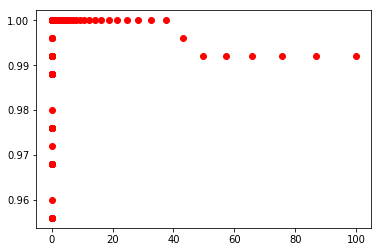

The maximum score 1.0 is at lamb = 14.174741629268047


In [40]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.7, random_state=0)

scores = []
C_list = np.geomspace(1e-4,1e2,100)
fig, ax = plt.subplots()

for lamb_inv in C_list:
    clf1 = LogisticRegression(C = lamb_inv, fit_intercept = False, random_state = 0, solver = "liblinear").fit(X_train,y_train)
    plt.hold = True
    ax.plot(lamb_inv, clf1.score(X_test,y_test),"ro")
    scores.append(clf1.score(X_test,y_test))

scores = np.array(scores)
lamb = 1/C_list[np.argmax(scores)]
plt.show()
print("The maximum score",np.max(scores),"is at lamb =",lamb)

## 1.2 Optimization Methods

In [172]:
def sigmoid(z):
    sigma =  1/(1+np.exp(-z))
    return sigma


def gradient(beta, X, y):
    update = np.zeros(beta.shape[0])
    for i in range(X.shape[0]):
        update = update + sigmoid(y[i]*np.dot(X[i,:],beta)) * y[i] * X[i,:]
    grad = (1/reg_param) * beta + (1/y.shape[0]) * update
    return grad

def gradient_achita(beta, X, y):
    N = y.shape[0]
    temp = sigmoid(-y*np.dot(X,beta))*y
    #Here is the correction of the grad
    result = beta - 1.0/N*(np.dot(X.T,temp))
    return result

def predict(beta,X):
    decision = np.dot(X,beta)
    y_computed = np.sign(decision)
    return y_computed

def zero_ones_loss(y_prediction, y_truth):
    zero_ones_vec = 1/2 * (y_prediction - y_truth)
    return np.dot(zero_ones_vec , zero_ones_vec)
    

## Algorithms

In [486]:
def gradient_descent(m,beta,X,y,tau):
    for i in range(m):
        beta = beta - tau * gradient(beta,X,y)
    return beta

def stochastic_gradient(m,beta,X,y,tau0,gamma):
    tau = tau0
    for i in range(m):
        tau = tau/(1+np.power(gamma,i))
        X_random = X[np.random.randint(0,X.shape[0]),:].reshape(1,65)
        beta = beta - tau * gradient(beta, X_random, y)
    return beta

def SG_mini_batch(m,beta,X,y,tau0,gamma,B):
    tau = tau0
    for i in range(m):
        tau = tau/(1+np.power(gamma,i))
        rows_random = np.random.choice(np.arange(X.shape[0]),B,replace = True)
        X_random = X[rows_random,:]
        beta = beta - tau * gradient(beta,X_random,y)
    return beta

def SG_momentum(m,beta,X,y,tau0,gamma,mu):
    g = np.zeros(65)
    tau = tau0
    for i in range(m):
        tau = tau/(1+np.power(gamma,i))
        X_random = X[np.random.randint(0,X.shape[0]),:].reshape(1,65)
        g = mu*g +(1-mu)*gradient(beta,X_random,y)
        beta = beta - tau*g
    return beta

def ADAM(m,beta,X,y,tau):
    g = 0
    q = 1
    mu1 = 0.9
    mu2 = 0.999
    epsilon = 1e-8
    for i in range(m):
        X_random = X[np.random.randint(0,X.shape[0]),:].reshape(1,65)
        grad = gradient(beta,X_random,y)     
        g = mu1*g + (1-mu1)*grad
        q = mu2*q + (1-mu2)*(grad*grad)
        g_tilt = g/(1-np.power(mu1,i+1))
        q_tilt = q/(1-np.power(mu2,i+1))  
        beta = beta - tau/(np.sqrt(q_tilt)+epsilon) * g_tilt
    return beta

def SAG(m,beta,X,y,tau0,gamma):
    g_stored = []
    tau = tau0
    for i in range(y.shape[0]):
        g_stored.append( y[i]* X[i] * sigmoid(-y[i] * np.dot( X[i] , beta)))
    g_stored = np.array(g_stored)
    g = np.sum(g_stored,axis = 0)/y.shape[0]
    for j in range(m):
        tau = tau/(1+np.power(gamma,j))
        i = np.random.randint(0,g_stored.shape[0])
        g_update = y[i] * np.dot( X[i] , sigmoid(-y[i]* np.dot(X[i] , beta)))
        g = g + 1/X.shape[0] *(g_update - g_stored[i])
        g_stored[i] = g_update
        beta = beta * (1- tau/reg_param) - tau*g 
    return beta


def DCA(m,X,y):
    alpha = np.random.rand(y.shape[0])    
    beta = reg_param/y.shape[0] * np.dot( alpha * y, X)
    for j in range(m):
        i = np.random.randint(alpha.shape[0])
        f1 = y[i]*np.dot(X[i],beta) + np.log(alpha[i]/(1-alpha[i]))      
        f2 = reg_param/y.shape[0] * np.dot(X[i],X[i]) + 1/(alpha[i]*(1-alpha[i]))       
        alpha_new = alpha[i] - f1/f2
        beta = beta + (reg_param/y.shape[0]) *y[i]* X[i] * (alpha_new - alpha[i])
    return beta


def newton_raphson(m,beta,X,y):
    for t in range(m):
        D = X.shape[1]
        N = X.shape[0]
        beta = np.zeros(D)
        z = np.dot( X , beta)
        y_tilt = y/sigmoid(np.dot(y,z))
        diag = np.array([reg_param/N*sigmoid(z[i])*sigmoid(-z[i]) for i in range(N)])
        W = np.diagflat(diag)
        beta = np.dot( np.dot( np.linalg.inv( np.identity(D) + np.dot ( np.dot(X.T , W) , X )) , np.dot(X.T,W) ), z + y_tilt)
    return beta

## 1.3 Comparison

In [ ]:
from sklearn.model_selection import train_test_split, KFold
X, X_test, y, y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.3,random_state=0)



In [505]:
from sklearn.model_selection import train_test_split, KFold

gamma_set = np.array([1e-4,1e-3,1e-2])
mu_set = np.array([0.1,0.2,0.5])
tau_set = np.array([1e-3,1e-2,1e-1])
b0 = np.zeros(65)


kf = sklearn.model_selection.KFold(n_splits = 10, shuffle = False, random_state = 0)
print("GradienDescent:")
for tau in tau_set:
    sum = 0
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        beta = gradient_descent(10,b0,X_train,y_train,tau)
        sum += zero_ones_loss(y_test, predict(-beta,X_test))
    print("The summarized loss for tau =",tau,"is",sum)

print("SGD:")
for tau in tau_set:
    for gamma in gamma_set:
        sum = 0
        count = 0
        for train_index, test_index in kf.split(X):
            count +=1
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            beta = stochastic_gradient(150,b0,X_train,y_train,tau,gamma)
            sum += zero_ones_loss(y_test, predict(beta,X_test))
        print("The summarized loss for tau =",tau,",gamma=",gamma,"is",sum)

GradienDescent:
The summarized loss for tau = 0.001 is 17.0
The summarized loss for tau = 0.01 is 18.0
The summarized loss for tau = 0.1 is 48.0
SGD:
The summarized loss for tau = 0.001 ,gamma= 0.0001 is 183.0
The summarized loss for tau = 0.001 ,gamma= 0.001 is 183.0
The summarized loss for tau = 0.001 ,gamma= 0.01 is 183.0
The summarized loss for tau = 0.01 ,gamma= 0.0001 is 183.0
The summarized loss for tau = 0.01 ,gamma= 0.001 is 183.0
The summarized loss for tau = 0.01 ,gamma= 0.01 is 183.0
The summarized loss for tau = 0.1 ,gamma= 0.0001 is 183.0
The summarized loss for tau = 0.1 ,gamma= 0.001 is 183.0
The summarized loss for tau = 0.1 ,gamma= 0.01 is 183.0


In [470]:
help(sklearn.model_selection.KFold)

Help on class KFold in module sklearn.model_selection._split:

class KFold(_BaseKFold)
 |  K-Folds cross-validator
 |  
 |  Provides train/test indices to split data in train/test sets. Split
 |  dataset into k consecutive folds (without shuffling by default).
 |  
 |  Each fold is then used once as a validation while the k - 1 remaining
 |  folds form the training set.
 |  
 |  Read more in the :ref:`User Guide <cross_validation>`.
 |  
 |  Parameters
 |  ----------
 |  n_splits : int, default=3
 |      Number of folds. Must be at least 2.
 |  
 |      .. versionchanged:: 0.20
 |          ``n_splits`` default value will change from 3 to 5 in v0.22.
 |  
 |  shuffle : boolean, optional
 |      Whether to shuffle the data before splitting into batches.
 |  
 |  random_state : int, RandomState instance or None, optional, default=None
 |      If int, random_state is the seed used by the random number generator;
 |      If RandomState instance, random_state is the random number generator;
